<a href="https://colab.research.google.com/github/Jacobmunoz88/modeladoysimulacion/blob/main/proyecto_mys_JMA_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

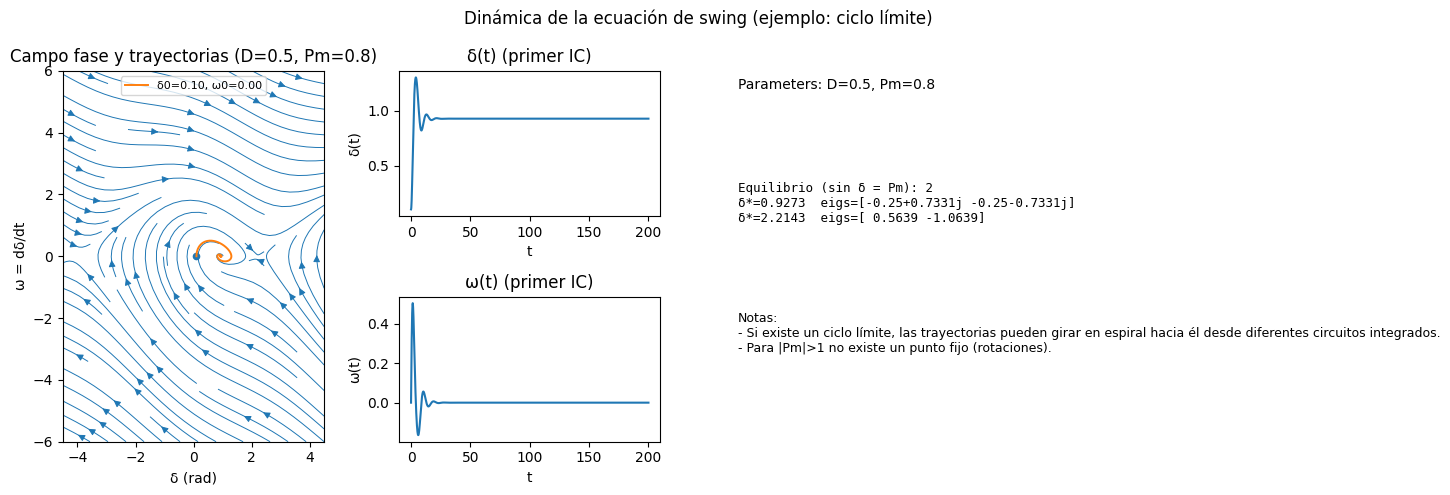

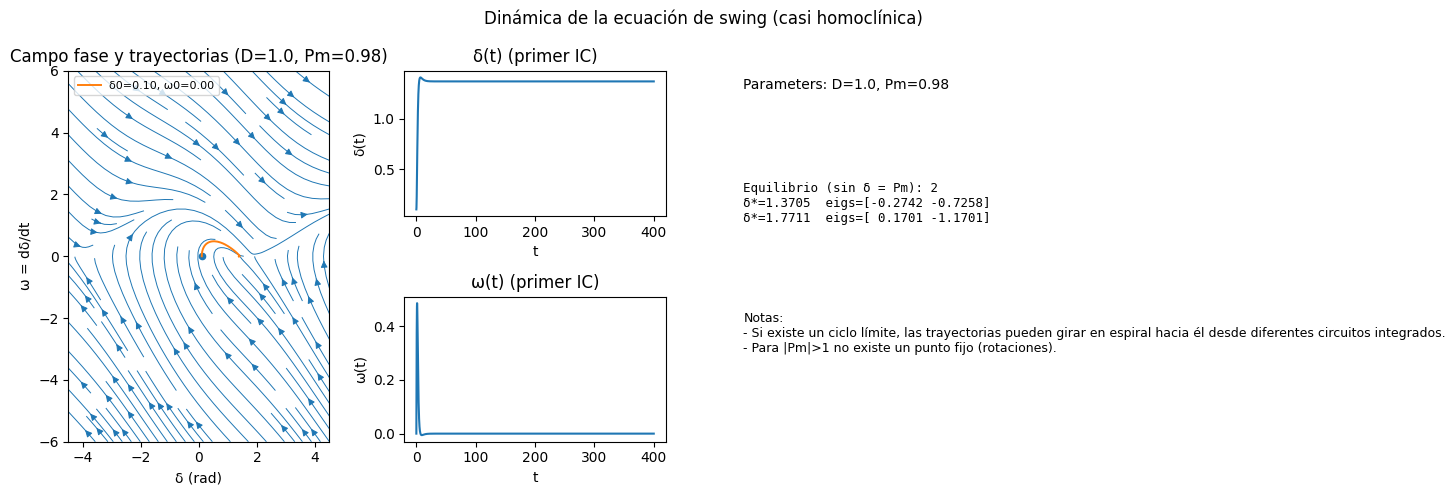

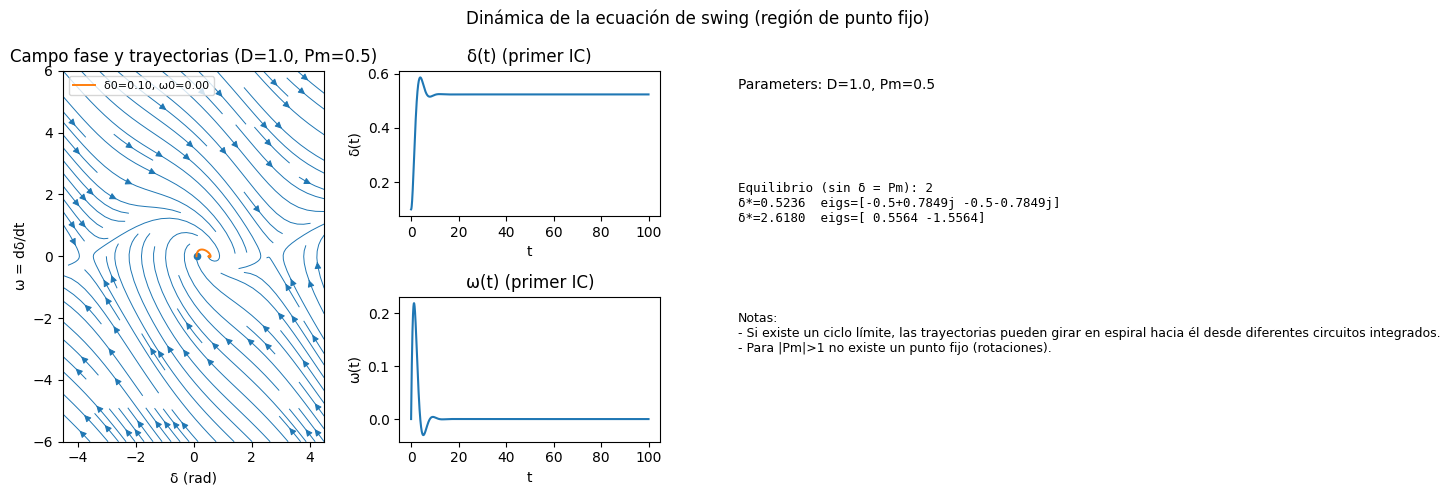

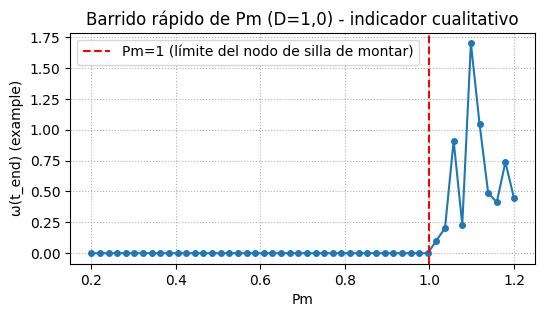

In [3]:
# ecuacion de oscilacion
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math

# --------------------------
# Definición del sistema
# --------------------------
def swing_rhs(t, y, D, Pm):
    delta, omega = y
    ddelta = omega
    domega = -D*omega - math.sin(delta) + Pm
    return [ddelta, domega]

# Jacobiano para mirar la estabilidad
def jacobian_at_equilibrium(delta_star, D):
    # linearization of [δ', ω']^T -> [[0,1],[-cos(δ*), -D]]
    J = np.array([[0.0, 1.0],
                  [-math.cos(delta_star), -D]])
    eigs = np.linalg.eigvals(J)
    return J, eigs

# Calculos de equilibrios y estabilidad
def equilibria_for_Pm(Pm):
    eqs = []
    if abs(Pm) <= 1.0:
        a = math.asin(Pm)
        eqs.append(a)
        eqs.append(math.pi - a)
        uniq = []
        for d in eqs:
            dmod = ((d + math.pi) % (2*math.pi)) - math.pi
            if all(abs(dmod - u) > 1e-6 for u in uniq):
                uniq.append(dmod)
        return uniq
    else:
        return []

# --------------------------
# Plot
# --------------------------
def plot_phase_field(ax, D, Pm, dlims, wlims, density=20):
    dmin, dmax = dlims
    wmin, wmax = wlims
    Dd = np.linspace(dmin, dmax, density)
    Ww = np.linspace(wmin, wmax, density)
    Dg, Wg = np.meshgrid(Dd, Ww)
    U = Wg
    V = -D*Wg - np.sin(Dg) + Pm
    speed = np.sqrt(U**2 + V**2)
    # normalize arrows for better plotting
    ax.streamplot(Dd, Ww, U, V, density=1.0, linewidth=0.7, arrowsize=1)
    ax.set_xlim(dmin, dmax)
    ax.set_ylim(wmin, wmax)
    ax.set_xlabel("δ (rad)")
    ax.set_ylabel("ω = dδ/dt")
    ax.set_title(f"Campo fase y trayectorias (D={D}, Pm={Pm})")

# --------------------------
# Simulacion
# --------------------------
def simulate_and_plot(D, Pm, ics, t_final=200.0, t_eval=None, title_suffix=""):
    if t_eval is None:
        t_eval = np.linspace(0, t_final, 4000)
    # region for phase plot (choose based on initial conditions)
    dlims = (-4.5, 4.5)
    wlims = (-6.0, 6.0)

    # Figure: phase portrait + sample trajectories
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(1,3,1)
    plot_phase_field(ax1, D, Pm, dlims, wlims)
    # simulate and plot trajectories on phase plane
    for ic in ics:
        sol = solve_ivp(swing_rhs, (t_eval[0], t_eval[-1]), ic, t_eval=t_eval, args=(D, Pm),
                        rtol=1e-8, atol=1e-10)
        ax1.plot(sol.y[0], sol.y[1], lw=1.4, label=f"δ0={ic[0]:.2f}, ω0={ic[1]:.2f}")
        ax1.scatter(ic[0], ic[1], s=20)
    ax1.legend(fontsize=8)


    sol0 = solve_ivp(swing_rhs, (t_eval[0], t_eval[-1]), ics[0], t_eval=t_eval, args=(D, Pm),
                     rtol=1e-8, atol=1e-10)
    ax2 = fig.add_subplot(2,3,2)
    ax2.plot(sol0.t, sol0.y[0])
    ax2.set_xlabel("t")
    ax2.set_ylabel("δ(t)")
    ax2.set_title("δ(t) (primer IC)")

    ax3 = fig.add_subplot(2,3,5)
    ax3.plot(sol0.t, sol0.y[1])
    ax3.set_xlabel("t")
    ax3.set_ylabel("ω(t)")
    ax3.set_title("ω(t) (primer IC)")

    # compute equilibria and linear stability
    eqs = equilibria_for_Pm(Pm)
    info_text = f"Equilibrio (sin δ = Pm): {len(eqs)}\n"
    for dstar in eqs:
        J, eigs = jacobian_at_equilibrium(dstar, D)
        info_text += f"δ*={dstar:.4f}  eigs={eigs.round(4)}\n"
    if len(eqs)==0:
        info_text += "Sin equilibrios (|Pm|>1) -> sin punto fijo; solo soluciones rotatorias.\n"

    # add text box with info
    ax4 = fig.add_subplot(1,3,3)
    ax4.axis('off')
    ax4.text(0.01, 0.98, f"Parameters: D={D}, Pm={Pm}\n", fontsize=10, va='top')
    ax4.text(0.01, 0.70, info_text, fontsize=9, va='top', family='monospace')
    ax4.text(0.01, 0.35, "Notas:\n- Si existe un ciclo límite, las trayectorias pueden girar en espiral hacia él desde diferentes circuitos integrados.\n- Para |Pm|>1 no existe un punto fijo (rotaciones).", fontsize=9, va='top')
    fig.suptitle(f"Dinámica de la ecuación de swing {title_suffix}", fontsize=12)
    plt.tight_layout()
    plt.show()

# --------------------------
# Example parameter sets (from paper / representative regimes)
# --------------------------
# 1) Stable limit cycle regime (paper example): D = 0.5, Pm = 0.8 (limit cycle region)
D1, Pm1 = 0.5, 0.8

# 2) Closer to homoclinic (distorted limit cycle): D = 1, Pm = 0.98
D2, Pm2 = 1.0, 0.98

# 3) Fixed point region example (Pm small): D = 1.0, Pm = 0.5
D3, Pm3 = 1.0, 0.5

# initial conditions to probe (different)
initial_conditions = [
    (0.1, 0.0)
]

# Run simulations & plots (these will produce 3 figures)
simulate_and_plot(D1, Pm1, initial_conditions, t_final=200.0, title_suffix="(ejemplo: ciclo límite)")
simulate_and_plot(D2, Pm2, initial_conditions, t_final=400.0, title_suffix="(casi homoclínica)")
simulate_and_plot(D3, Pm3, initial_conditions, t_final=100.0, title_suffix="(región de punto fijo)")

# --------------------------
# Optional: sweep Pm to see qualitative change (quick scan)
# --------------------------
def quick_Pm_sweep(D, Pm_values, ic=(0.2, 0.0), t_span=(0,200), t_eval=None):
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 3000)
    final_omega = []
    for Pm in Pm_values:
        sol = solve_ivp(swing_rhs, t_span, ic, t_eval=t_eval, args=(D, Pm))
        final_omega.append(sol.y[1,-1])
    return np.array(final_omega)

# Example quick sweep plot (D=1.0)
Pm_vals = np.linspace(0.2, 1.2, 50)
final_w = quick_Pm_sweep(1.0, Pm_vals)
plt.figure(figsize=(6,3))
plt.plot(Pm_vals, final_w, '-o', markersize=4)
plt.axvline(1.0, color='r', linestyle='--', label='Pm=1 (límite del nodo de silla de montar)')
plt.xlabel('Pm'); plt.ylabel('ω(t_end) (example)')
plt.title('Barrido rápido de Pm (D=1,0) - indicador cualitativo')
plt.grid(linestyle=':')
plt.legend()
plt.show()


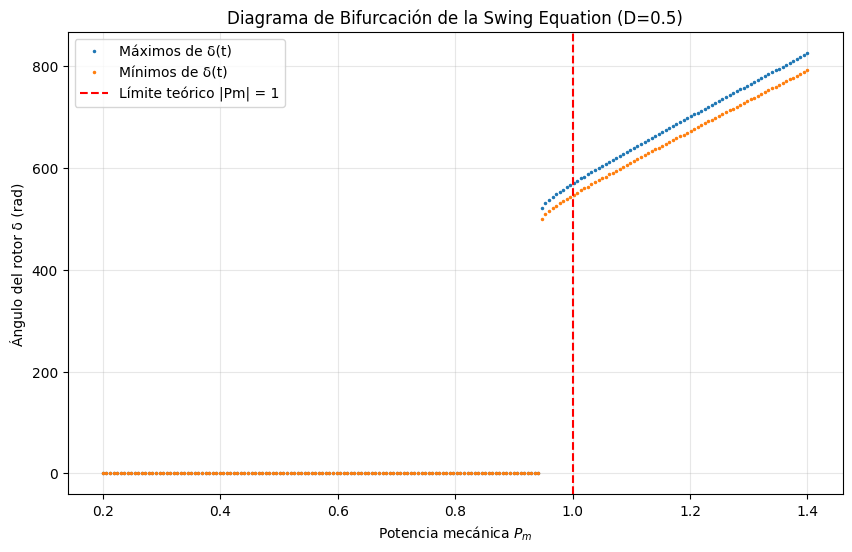

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math

# Swing Equation
def swing_equation(t, y, D, Pm):
    delta, omega = y
    ddelta = omega
    domega = -D*omega - math.sin(delta) + Pm
    return [ddelta, domega]

# Parámetro fijo
D = 0.5

# Barrido de Pm
Pm_values = np.linspace(0.2, 1.4, 200)

# Condición inicial
y0 = [0.1, 0.0]

# Listas para almacenar valores de bifurcación
delta_max = []
delta_min = []

t_eval = np.linspace(0, 300, 5000)

for Pm in Pm_values:
    sol = solve_ivp(swing_equation, (0,300), y0, args=(D,Pm),
                    t_eval=t_eval, rtol=1e-8, atol=1e-10)

    delta_values = sol.y[0][-200:]  # últimos valores (estado final)

    # Detectar oscilaciones vs equilibrio
    delta_max.append(np.max(delta_values))
    delta_min.append(np.min(delta_values))

# Graficar resultados
plt.figure(figsize=(10,6))
plt.plot(Pm_values, delta_max, '.', markersize=3, label='Máximos de δ(t)')
plt.plot(Pm_values, delta_min, '.', markersize=3, label='Mínimos de δ(t)')

plt.axvline(1.0, linestyle='--', color='r',
            label='Límite teórico |Pm| = 1')

plt.xlabel("Potencia mecánica $P_m$")
plt.ylabel("Ángulo del rotor δ (rad)")
plt.title("Diagrama de Bifurcación de la Swing Equation (D=0.5)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()
